# Stock Advisor

A simple to use notebook to help you stay informed on stock trends. Object implimentation is at the beginning: examples follow.

In [73]:
#Import lots of stuff
import heapq
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime
from statistics import mode
from scipy import stats
from scipy.stats import anderson
from scipy.stats import shapiro

#trying new plotting library
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook

## The simple moving average object
Simple moving average analysis of stocks. Best for trending markets (not sidways/violate markets)

This is a Simple Moving Crossover Trading Strategy (Momentum class of strategies)
The code comes from part of the tutorial form this website:
https://www.datacamp.com/community/tutorials/finance-python-trading#tradingstrategy


In [123]:
class sma:
    
    def __init__(self, ticker, start, end): #executed when an sma object in created
        self.ticker = ticker   #must be all caps string (e.g. "MSFT")
        self.startDate = start #must be datetime.datetime(yyyy,mm,dd)
        self.endDate = end     #must be datetime.datetime(yyyy,mm,dd)
        
        # Check for valid inputs
        
        if len(self.ticker) < 1: #check for valid ticker
            print("\nInvalid ticker: length is less than 1 character\n")
        
        if(type(end) != datetime.datetime or type(start) != datetime.datetime): #check dates are correct object
            print("\nInvalid date start and/or end object(s): datetime.datetime(yyyy,mm,dd) required for start and end dates\n")
        
        if start>end: #check end is after start
            print("\nInvalid dates: start date is after end date\n")
        
        # Import stock data using pandasreader
        self.df = pdr.get_data_quandl(self.ticker, start=self.startDate, end=self.endDate)
        self.df = self.df.reindex(index=self.df.index[::-1]) #flip index so 0th row is oldest date
        
    def viewDFhead(self):
        return self.df.head()
        
    def viewDFtail(self):
        return self.df.tail()
    
    def plotDF(self):
        #iteractive bokeh plot
        output_notebook() #puts plot inside notebook instead of making it in a new browser tab
        p = figure(title=self.ticker,x_axis_type='datetime',y_axis_label='Price $')
        p.line(self.df.index.values,self.df['Close'])
        show(p)
        
        #matplotlib version (not interactive)
        self.df['Close'].plot(grid=True,figsize=(12,8))
        plt.title(ticker)
        plt.ylabel('Price $')
        plt.show()
        
    def createSMA(self, window): #Calculate SMA for given window_size
        self.window = window
        
        # Initialize the signals DataFrame
        self.signals = pd.DataFrame(index=self.df.index)
        self.signals['signal'] = 0.0

        # Create short simple moving average over the short window
        self.signals['mavg'] = self.df['Close'].rolling(window=self.window, min_periods=1, center=False).mean()

    def getSMA(self):
        return self.signals
    
    def getDF(self):
        return self.df
        
    def plotSMA(self): #plot price with SMA short and long windows. For now, buy sell signals are not included
        fig = plt.figure()
        ax1 = fig.add_subplot(111, ylabel='Price in $')
        self.df['Close'].plot(ax=ax1, color='r', lw=2.)
        self.signals[['mavg']].plot(ax=ax1, lw=2.)
        plt.show()
        
        # Bohek plot (interactive)
        output_notebook() #puts plot inside notebook instead of making it in a new browser tab
        p = figure(title=self.ticker,x_axis_type='datetime',y_axis_label='Price $')
        p.line(self.df.index.values,self.df['Close'],color = 'red',legend='Close')
        p.line(self.df.index.values,self.signals['mavg'], color='green',legend=str(self.window))
        p.legend.click_policy="hide"
        show(p)
    
    def createBackTest(self, initial_capital):
    #Back tester
        # Set the initial capital
        initial_capital= float(initial_capital)

        # Create a DataFrame `positions`
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)

        # Buy a 10 shares at a time
        positions[ticker] = 10*self.signals['signal']   
  
        # Initialize the portfolio with value owned   
        self.portfolio = positions.multiply(self.df['AdjClose'], axis=0)

        # Store the difference in shares owned 
        pos_diff = positions.diff()

        # Add `holdings` to portfolio
        self.portfolio['holdings'] = (positions.multiply(self.df['AdjClose'], axis=0)).sum(axis=1)
        # Add `cash` to portfolio
        self.portfolio['cash'] = initial_capital - (pos_diff.multiply(self.df['AdjClose'], axis=0)).sum(axis=1).cumsum()   
        # Add `total` to portfolio
        self.portfolio['total'] = self.portfolio['cash'] + self.portfolio['holdings']
        # Add `returns` to portfolio
        self.portfolio['returns'] = self.portfolio['total'].pct_change()

        fig = plt.figure()
        ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
        self.portfolio['total'].plot(ax=ax1, lw=2.)
        plt.show()
        
        # Bohek plot (interactive)
        output_notebook() #puts plot inside notebook instead of making it in a new browser tab
        p = figure(title=self.ticker, x_axis_type='datetime', y_axis_label='Price $')
        p.line(self.df.index.values, self.portfolio['total'], color='red', legend='Total Profit $')
        p.legend.click_policy="hide"
        show(p)
        
    def evaluation(self):
        returns = self.portfolio['returns']

        # annualized Sharpe ratio
        sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

        # Print the Sharpe ratio
        print("Sharpe ratio:", sharpe_ratio)

        # Define a trailing 252 trading day window
        window = 252

        # Calculate the max drawdown in the past window days for each day
        rolling_max = self.df['AdjClose'].rolling(window, min_periods=1).max()
        daily_drawdown = self.df['AdjClose']/rolling_max - 1.0

        # Calculate the minimum (negative) daily drawdown
        max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

        # Plot the results
        daily_drawdown.plot()
        max_daily_drawdown.plot()
        plt.show()
        
        output_notebook() #puts plot inside notebook instead of making it in a new browser tab
        p = figure(title=self.ticker, x_axis_type='datetime', y_axis_label='Price $')
        p.line(self.df.index.values, daily_drawdown, color='red', legend='daily drawdown')
        p.line(self.df.index.values, max_daily_drawdown, color='blue', legend='max daily drawdown')
        p.legend.click_policy="hide"
        show(p)

        #Compound Annual Growth Rate
        days = (self.df.index[-1] - self.df.index[0]).days
        cagr = ((((self.df['AdjClose'][-1]) / self.df['AdjClose'][1])) ** (365.0/days)) - 1
        print("Compound Annual Growth Rate:",cagr)

In [155]:
ticker = 'MSFT'
start = datetime.datetime(2017, 5, 30)
end = datetime.datetime(2018, 12, 28)
sma1 = sma(ticker, start, end)
sma1.viewDFhead()
#sma1.plotDF() #redirects to new page

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2017-05-30,69.79,70.41,69.770,70.41,16901792.0,0.0,1.0,69.070641,69.684250,69.050847,69.684250,16901792.0
2017-05-31,70.53,70.74,69.810,69.84,29538356.0,0.0,1.0,69.803013,70.010849,69.090435,69.120125,29538356.0
2017-06-01,70.24,70.61,69.451,70.10,21066468.0,0.0,1.0,69.516002,69.882189,68.735135,69.377445,21066468.0
2017-06-02,70.44,71.86,70.240,71.76,34586054.0,0.0,1.0,69.713941,71.119304,69.516002,71.020335,34586054.0
2017-06-05,71.97,72.89,71.810,72.28,29507429.0,0.0,1.0,71.228170,72.138688,71.069820,71.534975,29507429.0


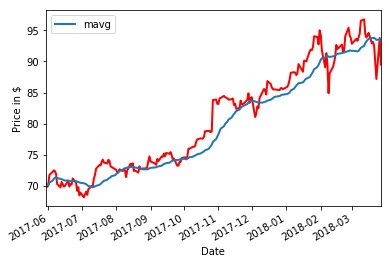

Loading BokehJS ...

In [156]:
sma1.createSMA(22)
sma1.plotSMA()

D'Agostino Test
p = 0.00809722
Sample may be normal (fail to reject)

Shapiro Test
Statistics=0.98039, p=0.00532
Sample may be normal (fail to reject)


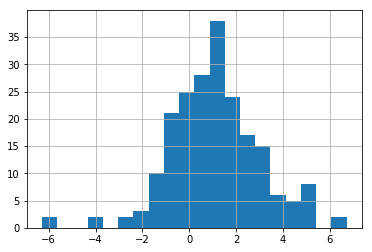

In [158]:
#Make normal distribution; count down from 365 and select largest window that is normal
#If distribution passes both tests, we'll call that normal

#Look into more tests?

sma1.createSMA(22)
df_signals = sma1.getSMA()
df2 = sma1.getDF()

df_signals['norm'] = df2['Close']-df_signals['mavg']
df_signals['norm'].hist(bins=20)

data = df_signals['norm']
alpha = 0.001

# null hypothesis: x comes from a normal distribution

# normality test
print("D'Agostino Test")
k2, p = stats.normaltest(data)
print("p = {:g}".format(p))
if p > alpha:
    print('Sample may be normal (fail to reject)')
else:
    print('Sample does not look normal (reject)')
    
# normality test
print("\nShapiro Test")
stat, p = shapiro(data)
print('Statistics=%.5f, p=%.5f' % (stat, p))
if p > alpha:
    print('Sample may be normal (fail to reject)')
else:
    print('Sample does not look normal (reject)')
    
    
# normality test
#result = anderson(data)
#print('Statistic: %.3f' % result.statistic)
#p = 0
#for i in range(len(result.critical_values)):
#    sl, cv = result.significance_level[i], result.critical_values[i]
#    if result.statistic < result.critical_values[i]:
#        print('%.3f: %.3f, data looks normal (fail to reject)' % (sl, cv))
#    else:
#        print('%.3f: %.3f, data does not look normal (reject)' % (sl, cv))

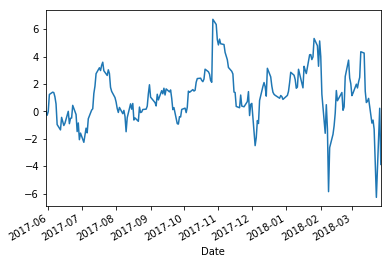

In [159]:
df_signals['norm'].plot()

In [160]:
#calculate percent difference between two standard deviations
print(df_signals['norm'].describe())
ave = df_signals['norm'].describe()[1]
low = df_signals['norm'].describe()[4]
high = df_signals['norm'].describe()[6]

#percent increase
todaysPrice = df2['Close'][-1]
high/todaysPrice

if todaysPrice > ave and todaysPrice < high:
    print('BUY!!')

#positive mean is upward trend
#negative mean is downward trend

count    208.000000
mean       1.103528
std        1.943956
min       -6.281818
25%       -0.025000
50%        1.160455
75%        2.247614
max        6.720909
Name: norm, dtype: float64


0.025121422112033515

In [162]:
#flag buy
norm_data = df_signals['norm']


### Evaluating strategy
1. Sharpe Ratio:
1 is ok, 2 is very good and 3 is excellent. (according to tutorial)
2. Maximum Drawdown:
measure of the largest single drop from peak to bottom
3. Compound Annual Growth Rate (CAGR): What you actual made over the time period as if a constant rate

In [122]:
sma1.evaluation()

AttributeError: 'sma' object has no attribute 'portfolio'